## Librerías

In [1]:
import numpy as np 
import pandas as pd
import joblib
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from skimage import feature, data, color 
import os
from tqdm import tqdm 
from skimage.transform import resize 
from skimage.io import imread
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain 
from scipy import stats 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from utils import optimize_model_and_faces_with_optuna #, extract_patches

#Metricas de performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.getcwd()

'/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio'

## Importar Caras y Fondos

In [3]:
suffix = '.pgm'

all_files = os.listdir('Faces/')
pgm_files = [filename for filename in all_files if filename.endswith(suffix)]

In [4]:
positive_patches = []
for filename in tqdm(pgm_files):
  path = 'Faces/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  positive_patches.append(image)

  5%|▌         | 657/12833 [00:00<00:03, 3394.00it/s]

100%|██████████| 12833/12833 [00:02<00:00, 4823.33it/s]


In [5]:
positive_patches = np.array(positive_patches)
positive_patches.shape

(12833, 64, 64)

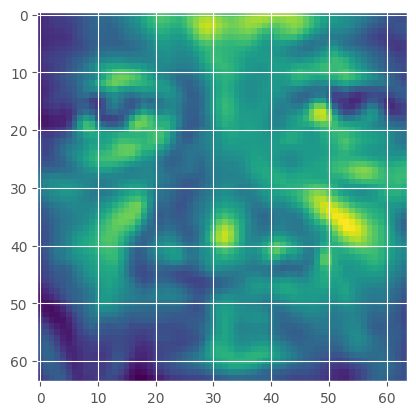

In [6]:
plt.imshow(positive_patches[1])
plt.show()

In [7]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size = (64, 64)):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [8]:
# Tomamos algunas imágenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

images = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
        img = (img * 255).astype(np.uint8)
    images.append(resize(img, (100,100)))

# Imagenes caseras adicionales
background_files = [f for f in os.listdir('Background') if f.endswith('.jpg')]
for filename in background_files:
    img = plt.imread('Background/' + filename)
    img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

In [9]:
# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 64, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape

Procesando imágenes: 100%|██████████| 60/60 [00:01<00:00, 42.84it/s]


(19200, 64, 64)

In [10]:
P = len(positive_patches)
N = len(negative_patches)

In [11]:
positive_patches = np.array(positive_patches)
print('positive_patches:',positive_patches.shape)

negative_patches = np.array(negative_patches)
print('negative_patches:',negative_patches.shape)

positive_patches: (12833, 64, 64)
negative_patches: (19200, 64, 64)


In [12]:
positive_patches

array([[[ 93, 109, 118, ..., 141, 141, 128],
        [ 88, 105, 116, ..., 136, 139, 134],
        [ 91, 105, 116, ..., 131, 135, 135],
        ...,
        [ 38,  34,  27, ..., 153, 188, 220],
        [ 35,  32,  26, ..., 199, 229, 234],
        [ 33,  32,  29, ..., 228, 240, 225]],

       [[ 68,  72,  76, ...,  88,  84,  82],
        [ 68,  73,  76, ...,  88,  87,  87],
        [ 69,  73,  75, ...,  87,  89,  90],
        ...,
        [ 84,  94,  96, ...,  99,  93,  88],
        [ 79,  90,  94, ...,  97,  92,  88],
        [ 74,  85,  90, ...,  94,  89,  88]],

       [[105, 109, 112, ..., 175, 166, 163],
        [105, 110, 113, ..., 173, 164, 159],
        [105, 109, 108, ..., 174, 166, 160],
        ...,
        [145, 140, 105, ..., 208, 146,  49],
        [132, 139, 115, ..., 208, 144,  40],
        [126, 133, 116, ..., 208, 148,  37]],

       ...,

       [[138, 142, 145, ..., 163, 148, 131],
        [141, 146, 148, ..., 162, 146, 129],
        [143, 149, 150, ..., 160, 145, 130

In [13]:
negative_patches

array([[[0.4317259 , 0.44254155, 0.45335721, ..., 0.50870194,
         0.50773631, 0.50677068],
        [0.4288775 , 0.43963401, 0.45039052, ..., 0.50785415,
         0.50678211, 0.50571007],
        [0.42602909, 0.43672646, 0.44742383, ..., 0.50700636,
         0.50582791, 0.50464945],
        ...,
        [0.56926828, 0.57183059, 0.57439289, ..., 0.39606439,
         0.40072611, 0.40538783],
        [0.56836983, 0.57090794, 0.57344605, ..., 0.40158727,
         0.40453217, 0.40747706],
        [0.56747138, 0.56998529, 0.5724992 , ..., 0.40711015,
         0.40833822, 0.40956629]],

       [[0.50395018, 0.50259958, 0.50124898, ..., 0.36731131,
         0.37341773, 0.37952414],
        [0.5063919 , 0.50499438, 0.50359686, ..., 0.35747061,
         0.36429876, 0.3711269 ],
        [0.50883362, 0.50738918, 0.50594473, ..., 0.34762991,
         0.35517979, 0.36272966],
        ...,
        [0.44839405, 0.43843179, 0.42846954, ..., 0.46971596,
         0.47061423, 0.47151251],
        [0.4

In [14]:
negative_patches = (negative_patches*255).astype(np.uint8)

negative_patches

array([[[110, 112, 115, ..., 129, 129, 129],
        [109, 112, 114, ..., 129, 129, 128],
        [108, 111, 114, ..., 129, 128, 128],
        ...,
        [145, 145, 146, ..., 100, 102, 103],
        [144, 145, 146, ..., 102, 103, 103],
        [144, 145, 145, ..., 103, 104, 104]],

       [[128, 128, 127, ...,  93,  95,  96],
        [129, 128, 128, ...,  91,  92,  94],
        [129, 129, 129, ...,  88,  90,  92],
        ...,
        [114, 111, 109, ..., 119, 120, 120],
        [115, 112, 110, ..., 119, 119, 120],
        [116, 113, 111, ..., 119, 119, 119]],

       [[141, 141, 141, ..., 147, 147, 146],
        [141, 141, 141, ..., 147, 147, 146],
        [141, 141, 141, ..., 147, 147, 147],
        ...,
        [142, 142, 142, ..., 146, 146, 145],
        [142, 142, 141, ..., 146, 146, 146],
        [141, 141, 141, ..., 146, 146, 146]],

       ...,

       [[104, 107, 110, ..., 201, 194, 204],
        [106, 110, 113, ..., 190, 196, 201],
        [121, 129, 133, ..., 214, 206, 211

In [16]:
X = np.array([feature.hog(im) for im in tqdm(chain(positive_patches, negative_patches), desc='Construyendo X')])
y = np.zeros(len(X))
y[:P] = 1

Construyendo X: 32033it [00:13, 2367.10it/s]


In [17]:
X

array([[0.11646401, 0.03128126, 0.00558129, ..., 0.        , 0.01059255,
        0.03064134],
       [0.05215952, 0.01875931, 0.08044653, ..., 0.03149585, 0.09934855,
        0.13186444],
       [0.09338918, 0.01034122, 0.00889002, ..., 0.00365123, 0.01220339,
        0.15453749],
       ...,
       [0.01412594, 0.        , 0.01198015, ..., 0.11166409, 0.24912053,
        0.04256966],
       [0.19824994, 0.07418107, 0.02699928, ..., 0.05689269, 0.13233471,
        0.1334669 ],
       [0.06520012, 0.00221218, 0.00569407, ..., 0.02781517, 0.06629227,
        0.        ]])

In [18]:
y

array([1., 1., 1., ..., 0., 0., 0.])

# Training & Test samples

In [19]:
# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaler

In [20]:
scaler = StandardScaler()
joblib.dump(scaler, 'models/scaler.joblib')

['models/scaler.joblib']

# Training

In [21]:
X_train_std = scaler.fit_transform(X_train)


## PCA

In [22]:
# Entrenar el modelo con PCA al conjunto de entrenamiento
# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=500, whiten=True)
X_train_pca = pca.fit(X_train_std)
X_train_pca_transform = pca.transform(X_train_std)
# X_train_pca_transform = pca.transform(X_train_pca)

In [23]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Obtener varianzas
var_explicada = X_train_pca.explained_variance_ratio_ 
var_acumulada = np.cumsum(var_explicada)

# Crear DataFrames para Plotly
df_var_explicada = pd.DataFrame({
    'Componente': range(1, len(var_explicada)+1),
    'Varianza': var_explicada
})

df_var_acumulada = pd.DataFrame({
    'Componente': range(1, len(var_acumulada)+1),
    'Varianza': var_acumulada
})

# Crear subplots usando Plotly Express
fig = make_subplots(rows=1, cols=2, subplot_titles=('Varianza explicada por componente', 'Varianza acumulada'))

# Varianza explicada
fig.add_trace(
    go.Bar(
        x=df_var_explicada['Componente'], 
        y=df_var_explicada['Varianza'], 
        name='Varianza explicada',
        marker_color='#1f77b4',  # Azul más oscuro
        opacity=0.8
    ),
    row=1, col=1
)

# Varianza acumulada
fig.add_trace(
    go.Bar(
        x=df_var_acumulada['Componente'], 
        y=df_var_acumulada['Varianza'], 
        name='Varianza acumulada',
        marker_color='#2ca02c',  # Verde más oscuro
        opacity=0.8
    ),
    row=1, col=2
)

# Agregar línea de 95% de varianza
fig.add_hline(
    y=0.95, 
    line_dash="dash", 
    line_color="red",
    line_width=2,
    row=1, 
    col=2
)

# Actualizar layout
fig.update_layout(
    height=500,
    width=1200,
    showlegend=True,
    title_text="Análisis de Varianza PCA",
    title_font_size=20,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis_title="Componente principal",
    yaxis_title="Proporción de varianza",
    xaxis2_title="Componente principal",
    yaxis2_title="Proporción de varianza",
    font=dict(size=12),
    margin=dict(t=100)
)

# Actualizar ejes para mejor visualización
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

fig.show()

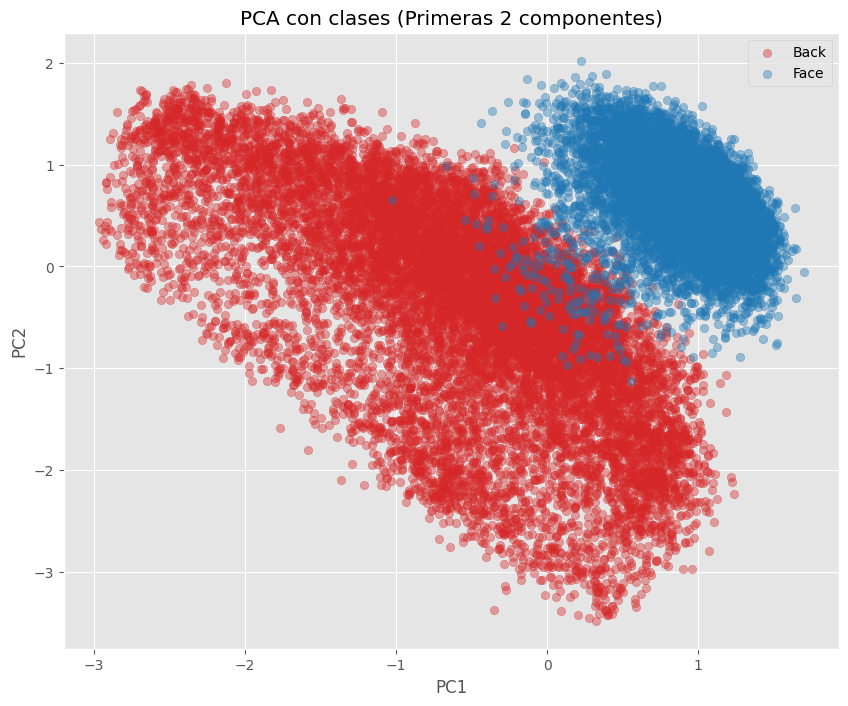

In [24]:
# Tomar solo las primeras dos componentes para graficar
X_plot = X_train_pca_transform[:, :2]

# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

plt.figure(figsize=(10, 8))
for class_value in [0, 1]:
    plt.scatter(X_plot[y_train == class_value, 0], 
                X_plot[y_train == class_value, 1], 
                c=colors[class_value], 
                label=labels[class_value], 
                alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases (Primeras 2 componentes)')
plt.legend()
plt.grid(True)
plt.show()

# Test

In [25]:
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

In [26]:
print(X_train_pca_transform.shape)
print(X_test_pca.shape)
print(y_train.shape)
print(y_test.shape)

(22423, 500)
(9610, 500)
(22423,)
(9610,)


# Modelos

## KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from re import A

In [28]:
k = 3

knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn.fit(X_train_pca_transform, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [29]:
y_train_pred =knn.predict(X_train_pca_transform)
y_test_pred = knn.predict(X_test_pca)

print('Accuracy train:',accuracy_score(y_train,y_train_pred))
print('Accuracy test: ',accuracy_score(y_test,y_test_pred))

Accuracy train: 0.6169112072425634
Accuracy test:  0.5963579604578564


In [30]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76     13489
         1.0       1.00      0.04      0.07      8934

    accuracy                           0.62     22423
   macro avg       0.81      0.52      0.42     22423
weighted avg       0.77      0.62      0.49     22423



In [31]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75      5711
         1.0       1.00      0.01      0.01      3899

    accuracy                           0.60      9610
   macro avg       0.80      0.50      0.38      9610
weighted avg       0.76      0.60      0.45      9610



In [32]:
joblib.dump(knn, 'models/knn_model.joblib')

['models/knn_model.joblib']

## Gaussian Naive Bayes

In [33]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
GNB.fit(X_train_pca_transform, y_train)

GaussianNB()

In [34]:
y_train_pred = GNB.predict(X_train_pca_transform)

In [35]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13489
         1.0       0.97      0.93      0.95      8934

    accuracy                           0.96     22423
   macro avg       0.96      0.96      0.96     22423
weighted avg       0.96      0.96      0.96     22423



In [36]:
y_test_pred = GNB.predict(X_test_pca)

In [37]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      5711
         1.0       0.97      0.92      0.95      3899

    accuracy                           0.96      9610
   macro avg       0.96      0.95      0.96      9610
weighted avg       0.96      0.96      0.96      9610



In [ ]:
joblib.dump(GNB, 'models/knn_model.joblib')

## XGBoost

In [38]:
import optuna
import xgboost as xgb

In [50]:
# ... existing code ...
def objective(trial):
    # Sugerir hiperparámetros para XGBoost
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'eval_metric': 'logloss'
    }
    
    # Crear y entrenar el modelo XGBoost con los parámetros sugeridos
    model_trial = xgb.XGBClassifier(**param, n_jobs=-1, random_state=42)
    
    # Evaluar el modelo usando validación cruzada
    cv_scores = cross_val_score(model_trial, X_train_pca_transform, y_train, 
                               cv=5, scoring='f1', n_jobs=-1)
    
    # Retornar el promedio de las puntuaciones de validación cruzada
    return cv_scores.mean()

In [51]:
# Create a study object and optimize
print("Iniciando optimización de hiperparámetros para XGBoost con Optuna...")
study = optuna.create_study(direction='maximize')  # Queremos maximizar el F1-score
study.optimize(objective, n_trials=50)  # Puedes aumentar n_trials para mejores resultados

print("¡Optimización completada!")
print(f"Mejor trial: {study.best_trial.number}")
print(f"Mejor F1-score: {study.best_value:.4f}")
print("Mejores hiperparámetros para XGBoost:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


[I 2025-06-28 14:52:05,047] A new study created in memory with name: no-name-07cfa8c0-243a-418f-b75d-97a9384ab29d


Iniciando optimización de hiperparámetros para XGBoost con Optuna...


[I 2025-06-28 14:52:32,300] Trial 0 finished with value: 0.9914838172295237 and parameters: {'n_estimators': 232, 'max_depth': 11, 'learning_rate': 0.015098266910754015, 'subsample': 0.9776279519463722, 'colsample_bytree': 0.62893797502202, 'gamma': 1.0487427055590688, 'reg_alpha': 1.8069771184322052, 'reg_lambda': 2.1111491275864807}. Best is trial 0 with value: 0.9914838172295237.
[I 2025-06-28 14:52:43,579] Trial 1 finished with value: 0.98532681858678 and parameters: {'n_estimators': 206, 'max_depth': 12, 'learning_rate': 0.004961790146941726, 'subsample': 0.8468228909564025, 'colsample_bytree': 0.9294184811551136, 'gamma': 4.5584221487380026, 'reg_alpha': 4.493685305722094, 'reg_lambda': 4.355601790373132}. Best is trial 0 with value: 0.9914838172295237.
[I 2025-06-28 14:53:00,982] Trial 2 finished with value: 0.9918940650875822 and parameters: {'n_estimators': 251, 'max_depth': 9, 'learning_rate': 0.046217728612877346, 'subsample': 0.9131975500336329, 'colsample_bytree': 0.879319

¡Optimización completada!
Mejor trial: 47
Mejor F1-score: 0.9935
Mejores hiperparámetros para XGBoost:
  n_estimators: 261
  max_depth: 8
  learning_rate: 0.16871572609158927
  subsample: 0.535733969829429
  colsample_bytree: 0.6518439967901378
  gamma: 0.7155363671038684
  reg_alpha: 0.36144821340821337
  reg_lambda: 4.293815183724652


In [59]:
# Train the final model with the best parameters
best_params = study.best_params

# Crear y entrenar XGBClassifier con los mejores hiperparámetros
XGB = xgb.XGBClassifier(**best_params, n_jobs=-1, random_state=42)
XGB.fit(X_train_pca_transform, y_train)

print("¡Modelo XGBoost optimizado entrenado exitosamente!")
print("Mejores hiperparámetros encontrados:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

¡Modelo XGBoost optimizado entrenado exitosamente!
Mejores hiperparámetros encontrados:
  n_estimators: 261
  max_depth: 8
  learning_rate: 0.16871572609158927
  subsample: 0.535733969829429
  colsample_bytree: 0.6518439967901378
  gamma: 0.7155363671038684
  reg_alpha: 0.36144821340821337
  reg_lambda: 4.293815183724652


In [60]:
# Evaluate the optimized model on validation data
X_test_pca_optimized = X_test_pca  # Use the existing validation PCA transformation
y_test_pred_optimized = XGB.predict(X_test_pca)

print("=== OPTIMIZED MODEL - VALIDATION RESULTS ===")
print(classification_report(y_test, y_test_pred_optimized))
y_val_pred_optimized = XGB.predict(X_test_pca_optimized)

print("=== OPTIMIZED MODEL - VALIDATION RESULTS ===")
print(classification_report(y_test, y_val_pred_optimized))


=== OPTIMIZED MODEL - VALIDATION RESULTS ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      5711
         1.0       1.00      0.99      0.99      3899

    accuracy                           1.00      9610
   macro avg       1.00      0.99      0.99      9610
weighted avg       1.00      1.00      1.00      9610

=== OPTIMIZED MODEL - VALIDATION RESULTS ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      5711
         1.0       1.00      0.99      0.99      3899

    accuracy                           1.00      9610
   macro avg       1.00      0.99      0.99      9610
weighted avg       1.00      1.00      1.00      9610



In [ ]:
# Save the optimized GaussianNB model
joblib.dump(XGB, 'models/xgboost_optimizado.joblib')

## NN

In [15]:
#import xgboost as xgb
#
#xgb_c = xgb.XGBClassifier


from sklearn.neural_network import MLPClassifier  

In [16]:
params = {
    # Arquitectura de la red
    'n_layers': {'type': 'int', 'low': 1, 'high': 3}, # Número de capas ocultas
    'n_units_l0': {'type': 'int', 'low': 32, 'high': 256, 'log': True}, # Neuronas para la primera capa
    'n_units_l1': {'type': 'int', 'low': 32, 'high': 256, 'log': True}, # Neuronas para la segunda capa (si n_layers >= 2)
    'n_units_l2': {'type': 'int', 'low': 32, 'high': 256, 'log': True}, # Neuronas para la tercera capa (si n_layers == 3)

    # Función de activación
    'activation': {'type': 'categorical', 'choices': ['relu', 'tanh']},

    # Algoritmo de optimización
    'solver': {'type': 'categorical', 'choices': ['adam', 'sgd']},

    # Regularización L2
    'alpha': {'type': 'float', 'low': 1e-5, 'high': 1e-2, 'log': True}, # Término de penalización L2

    # Tasa de aprendizaje inicial (especialmente relevante para 'sgd', 'adam' la gestiona mejor)
    'learning_rate_init': {'type': 'float', 'low': 1e-4, 'high': 1e-2, 'log': True},

    # Tamaño del batch (si el solver lo soporta, como 'adam' o 'sgd')
    'batch_size': {'type': 'categorical', 'choices': [32, 64, 128]}, # Comunes para datasets medianos

    # Número máximo de iteraciones (épocas)
    'max_iter': {'type': 'int', 'low': 200, 'high': 1000},

    # Parámetros específicos para el solver 'sgd'
    'momentum': {'type': 'float', 'low': 0.8, 'high': 0.99}, # Aplicable solo si solver='sgd'
    'nesterovs_momentum': {'type': 'categorical', 'choices': [True, False]} # Aplicable solo si solver='sgd'
}

In [17]:
optimize_model_and_faces_with_optuna(
    positive_patches, 
    negative_patches,
    model_class=MLPClassifier,
    param_distributions=params,
    n_trials=50,
    cv_folds=5,
    test_size=0.2,  # Solo para evaluación final
    random_state=42,
    n_jobs=-1,
    show_progress=True,
    optimize_faces=True,
    optimize_pca=False,
    fixed_pca_params={'n_components': 500, 'whiten': True}
)

[I 2025-06-28 17:41:07,100] A new study created in memory with name: no-name-d00eeaa9-ae0b-4d50-b3c2-039bd980f6b5


Starting model-agnostic optimization with Optuna...
Model: MLPClassifier
Parameters to optimize: ['n_layers', 'n_units_l0', 'n_units_l1', 'n_units_l2', 'activation', 'solver', 'alpha', 'learning_rate_init', 'batch_size', 'max_iter', 'momentum', 'nesterovs_momentum']
Also optimizing: Number of faces (P)
Trials: 50
CV folds: 5


  0%|          | 0/50 [00:00<?, ?it/s]/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(
Best trial: 0. Best value: 0:   2%|▏         | 1/50 [00:19<15:56, 19.51s/it]

Trial failed with error: __init__() got an unexpected keyword argument 'n_units_l2'
[I 2025-06-28 17:41:26,613] Trial 0 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 90, 'n_units_l1': 35, 'n_units_l2': 115, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.00019341597461768224, 'learning_rate_init': 0.00022102989393281994, 'batch_size': 32, 'max_iter': 405, 'momentum': 0.9364923337803037, 'nesterovs_momentum': True, 'n_positive_samples': 6500}. Best is trial 0 with value: 0.0.


/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(
Best trial: 0. Best value: 0:   2%|▏         | 1/50 [01:07<55:28, 67.94s/it]


[W 2025-06-28 17:42:15,004] Trial 1 failed with parameters: {'n_layers': 3, 'n_units_l0': 59, 'n_units_l1': 220, 'n_units_l2': 187, 'activation': 'tanh', 'solver': 'adam', 'alpha': 5.332333272572091e-05, 'learning_rate_init': 0.0051162673207690475, 'batch_size': 64, 'max_iter': 328, 'momentum': 0.9050852498382979, 'nesterovs_momentum': False, 'n_positive_samples': 8000} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio/utils.py", line 204, in objective
    cv_scores = cross_val_score(
  File "/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
  File "/Users/rodrigobenitez/Library/Python/3.9/lib/python/site-packa

KeyboardInterrupt: 